# Titanic - Machine Learning from Disaster
## 理解题目
主要就是预测乘客是否存活，训练集中有乘客的若干特征与存活情况，乘客特征是年龄，性别等信息。使用训练集训练出一个模型，然后利用该模型去预测测试集中乘客的存活情况。

## 数据准备

In [5]:
import pandas as pd
import numpy as np
import random

#Visualization
import pandas_profiling as ppf
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from collections import Counter

from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
from xgboost import XGBClassifier

In [6]:
# 读入数据
train_df = pd.read_csv('input/train.csv')
test_df = pd.read_csv('input/test.csv')
combin = [train_df, test_df]

## 理解数据
pandas_profiling库是理解数据的一个神器，可以生成数据报告，大大节省了我们理解数据的时间。

In [7]:
#ppf.ProfileReport(train_df)

## 清洗数据
### 查看缺失值多占比列

In [8]:
#查看缺失值所占比列
total = train_df.isnull().sum().sort_values(ascending=False)
percent=(train_df.isnull().sum()/len(train_df)).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['total', 'percent'])
missing_data 

,total,percent
Cabin,687,0.771044
Age,177,0.198653
Embarked,2,0.002245
PassengerId,0,0.000000
Survived,0,0.000000
Pclass,0,0.000000
Name,0,0.000000
Sex,0,0.000000
SibSp,0,0.000000
Parch,0,0.000000


In [9]:
#查看缺失值所占比列
total = test_df.isnull().sum().sort_values(ascending=False)
percent=(test_df.isnull().sum()/len(test_df)).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['total', 'percent'])
missing_data 

,total,percent
Cabin,327,0.782297
Age,86,0.205742
Fare,1,0.002392
PassengerId,0,0.000000
Pclass,0,0.000000
Name,0,0.000000
Sex,0,0.000000
SibSp,0,0.000000
Parch,0,0.000000
Ticket,0,0.000000


### 解决缺失值
根据上面生成的数据报告和所占比列,可以看到特征Carbin缺失较多，已经超过半数，补全也没有什么意义，可直接删掉这一列。查看报告中的相关性，可以删掉PassengerId，Ticket。

In [10]:
drop_column = ['PassengerId','Cabin', 'Ticket']
train_df.drop(drop_column, axis=1, inplace = True)
test_df.drop(drop_column, axis=1, inplace = True)

接下来解决Age和Embarked中缺失的值，可以采用中位数，众数，平均数来填充，可以都试一下。

In [11]:
for df in combin:
    df['Age'].fillna(df['Age'].median(), inplace=True)
    df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)
    df['Fare'].fillna(df['Fare'].mean(), inplace=True)

In [12]:
#查看缺失值所占比列
total = train_df.isnull().sum().sort_values(ascending=False)
percent=(train_df.isnull().sum()/len(train_df)).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['total', 'percent'])
missing_data

,total,percent
Survived,0,0.0
Pclass,0,0.0
Name,0,0.0
Sex,0,0.0
Age,0,0.0
SibSp,0,0.0
Parch,0,0.0
Fare,0,0.0
Embarked,0,0.0


In [13]:
#查看缺失值所占比列
total = test_df.isnull().sum().sort_values(ascending=False)
percent=(test_df.isnull().sum()/len(test_df)).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['total', 'percent'])
missing_data 

,total,percent
Pclass,0,0.0
Name,0,0.0
Sex,0,0.0
Age,0,0.0
SibSp,0,0.0
Parch,0,0.0
Fare,0,0.0
Embarked,0,0.0


目前缺失值都已经处理好，接着处理非数值的特征，及特征工程

## 数据转换
数据类型可以简单划分为数值型和非数值型。数值型有连续型和离散型。非数值型有类别型和非类别型，其中类别型特征中如果类别存在排序问题为定序型，若不存在排序问题则为定类型，非类别型是字符串型。如下所示：
1. 连续型 Continuous
    Real values: Temperature, Height, Weight …
2. 离散型 Discrete
    Integer values: Number of people …
3. 定序型 Ordinal
    Rankings: {Average, Good, Best}, {Low, Medium, High} …
4. 定类型 Nominal
    Symbols: {Teacher, Worker, Salesman}, {Red, Green, Blue} …
5. 字符串型 String
    Text: “Tsinghua University”, “No. 123, Pingan Avenue” …

对于非数值型，我们需要进行类别转换，即将非数值型转换为数值型，以方便机器学习算法后续处理。
先来看一下数据类型

In [14]:
train_df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S


Name, Sex, Embarked都为非数值型数据，其中Name为非类别型，Sex和Embarked为类别型,可以将Name转换为名字长度，再用dummy函数将Sex和Embarked变为one-hot编码,也叫哑变量处理。

In [15]:
train_df['Name_length'] = train_df['Name'].apply(len)
test_df['Name_length'] = test_df['Name'].apply(len)
train_df.drop('Name', axis=1, inplace=True)
test_df.drop('Name', axis=1, inplace=True)

In [16]:
test_df

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Name_length
0,3,male,34.5,0,0,7.8292,Q,16
1,3,female,47.0,1,0,7.0000,S,32
2,2,male,62.0,0,0,9.6875,Q,25
3,3,male,27.0,0,0,8.6625,S,16
4,3,female,22.0,1,1,12.2875,S,44
...,...,...,...,...,...,...,...,...
413,3,male,27.0,0,0,8.0500,S,18
414,1,female,39.0,0,0,108.9000,C,28
415,3,male,38.5,0,0,7.2500,S,28
416,3,male,27.0,0,0,8.0500,S,19


In [17]:
train_df_dummy = pd.get_dummies(train_df)
test_df_dummy = pd.get_dummies(test_df)

## 特征选择
现在已经将所有特征转换为数值型，接下来可以根据数据报告来选择我们需要的特征。

In [18]:
#ppf.ProfileReport(test_df_dummy)

## 评估算法
### 数据集划分
这一部分，可以使用随机划分，或者是随机抽样，分层抽样等，sklearn都有相应的库函数进行调用， 分离完训练集和测试集之后，测试集放在一边不用管，拿训练集进行下面的模型评估

In [19]:
# 划分训练集和测试集
X_train = train_df_dummy.drop('Survived', axis=1)
Y_train = train_df_dummy['Survived']
X_test = test_df_dummy.copy()

# 标准化
X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

X_train.shape, Y_train.shape, X_test.shape

((891, 11), (891,), (418, 11))

### 评估模型

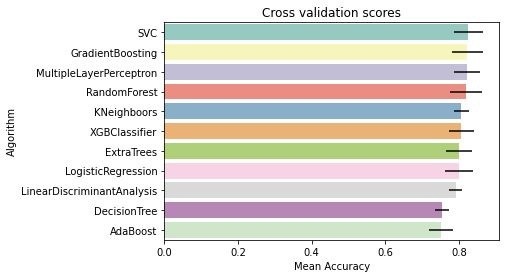

In [20]:
# Cross validate model with Kfold stratified cross val
kfold = StratifiedKFold(n_splits=10)

# Modeling step Test differents algorithms 
classifiers = []
classifiers.append(SVC())
classifiers.append(DecisionTreeClassifier())
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(),learning_rate=0.1))
classifiers.append(RandomForestClassifier())
classifiers.append(ExtraTreesClassifier())
classifiers.append(GradientBoostingClassifier())
classifiers.append(MLPClassifier())
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression())
classifiers.append(LinearDiscriminantAnalysis())
classifiers.append(XGBClassifier())

cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y = Y_train, scoring = "accuracy", cv = kfold, n_jobs=4))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["SVC","DecisionTree","AdaBoost",
"RandomForest","ExtraTrees","GradientBoosting","MultipleLayerPerceptron","KNeighboors","LogisticRegression","LinearDiscriminantAnalysis","XGBClassifier"]})

cv_res.sort_values(by=["CrossValMeans"], ascending=False, inplace=True)
g = sns.barplot(x="CrossValMeans",y="Algorithm", data=cv_res,palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

## 优化模型
###  算法调参
从上面表现比较好的模型中选出2-3个，可以尝试进行合理的参数搜索，找到合适的参数。
选择排名较高的模型，RandomForest, SVC, GradientBoosting这三个模型，分别调参选择最合适的参数

In [21]:
# RandomForest
RFC = RandomForestClassifier()

## Search grid for optimal parameters
rf_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsRFC.fit(X_train,Y_train)

RFC_best = gsRFC.best_estimator_

# Best score
gsRFC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


0.8316978776529339

In [22]:
# Gradient boosting tunning

GBC = GradientBoostingClassifier()
gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [100,200,300],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1] 
              }

gsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsGBC.fit(X_train,Y_train)

GBC_best = gsGBC.best_estimator_

# Best score
gsGBC.best_score_

Fitting 10 folds for each of 72 candidates, totalling 720 fits


0.8204494382022472

In [23]:
### SVC classifier
SVMC = SVC(probability=True)
svc_param_grid = {'kernel': ['rbf'], 
                  'gamma': [ 0.001, 0.01, 0.1, 1],
                  'C': [1, 10, 50, 100,200,300, 1000]}

gsSVMC = GridSearchCV(SVMC,param_grid = svc_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsSVMC.fit(X_train,Y_train)

SVMC_best = gsSVMC.best_estimator_

# Best score
gsSVMC.best_score_

Fitting 10 folds for each of 28 candidates, totalling 280 fits


0.8294132334581773

### 集成算法
现在的比赛中，用一种算法是不行的，需要几种模型放在一块集成或者堆叠等， 其实XGB，lightgbm，Adaboost等都是一些直接封装好的集成方法，但是现在在这个的基础上还有了一些新的集成和堆叠或者模型融合的技术。

In [24]:
votingC = VotingClassifier(estimators=[('rfc', RFC_best), 
('svc', SVMC_best), ('gbc',GBC_best)], voting='soft', n_jobs=4)

votingC = votingC.fit(X_train, Y_train)
votingC

VotingClassifier(estimators=[('rfc',
                              RandomForestClassifier(bootstrap=False,
                                                     max_features=3,
                                                     min_samples_leaf=3,
                                                     min_samples_split=10)),
                             ('svc', SVC(C=50, gamma=0.01, probability=True)),
                             ('gbc',
                              GradientBoostingClassifier(max_depth=4,
                                                         max_features=0.3,
                                                         min_samples_leaf=100,
                                                         n_estimators=300))],
                 n_jobs=4, voting='soft')

## 验证模型
选取出合适的模型（集成的或者堆叠的），然后就带入测试集，进行预测得出结果，根据比赛要求的格式进行文件的保存，提交。

In [27]:
Y_pred = pd.Series(votingC.predict(X_test), name="Survived")

test_df = pd.read_csv('input/test.csv')

submission = pd.DataFrame({
        "PassengerId": test_df["PassengerId"],
        "Survived": Y_pred
    })
submission.to_csv('output/submission.csv', index=False)

## 参考
https://blog.csdn.net/qq_35456045/article/details/104983889
https://www.kaggle.com/yassineghouzam/titanic-top-4-with-ensemble-modeling